#### 실행 위치: input/code/ensemble.ipynb
#### 앙상블할 csv파일들 위치: input/code/output_csv/
#### csv파일 이름: mIoU값이 먼저 오도록 설정(점수순으로 정렬하기 위함) ex) 7067_beit.csv

In [81]:
import pandas as pd
import numpy as np
from PIL import Image

from tqdm import tqdm
import os

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import webcolors
plt.rcParams['axes.grid'] = False

In [ ]:
output_list = os.listdir('./output_csv')
if '.ipynb_checkpoints' in output_list:
    output_list.remove('.ipynb_checkpoints')
output_list.sort(reverse=True)

# pandas dataframe으로 만들어줍니다.
df_list = []

for output in output_list:
    df_list.append(pd.read_csv(f'./output_csv/{output}'))

print('ensemble {} csv files'.format(len(df_list)))
    
# submission dataframe
submission = pd.DataFrame()
submission['image_id'] = df_list[0]['image_id']

# pixel-wise hard voting 진행
PredictionString = []

for idx in tqdm(range(len(df_list[0]))):
    # 각 모델이 뽑은 pixel 넣을 리스트
    pixel_list = []
    
    for i in range(len(df_list)):
        pixel_list.append(df_list[i]['PredictionString'][idx].split(' '))

    result = ''

    for i in range(len(pixel_list[0])):
        pixel_count = {'0' : 0, '1' : 0, '2' : 0, 
                      '3' : 0, '4' : 0, '5' : 0,
                      '6' : 0, '7' : 0, '8' : 0,
                      '9' : 0, '10' : 0}
        
        # 각 모델이 뽑은 pixel count
        for j in range(len(pixel_list)):
            pixel_count[pixel_list[j][i]] += 1
        
        # 제일 많이 vote된 pixel 값
        voted_pixel = [key for key, value in pixel_count.items() if value == max(pixel_count.values())]

        # voted_pixel이 1개인 경우
        if len(voted_pixel) == 1:
            result += voted_pixel[0] + ' '
        # 동점이 나온 경우
        else:
            # 성능이 좋았던 모델부터 값이 voted_pixel에 있다면 result로 고르기
            for j in range(len(pixel_list)):
                pixel_candidate = pixel_list[j][i]

                if pixel_candidate in voted_pixel:
                    result += pixel_candidate + ' '
                    break
    
    # 마지막 공백 제거
    result = result[:-1]

    PredictionString.append(result)
    
# submission csv 만들기
submission['PredictionString'] = PredictionString
submission.to_csv('./hard_voted_output.csv', index=False)

  0%|          | 0/624 [00:00<?, ?it/s]

ensemble 3 csv files


100%|██████████| 624/624 [05:11<00:00,  2.00it/s]


### Extra) 결과 분석 및 시각화

#### 성능 가장 좋았던 csv에서 바뀐 픽셀 비율

In [91]:
best = pd.read_csv('./output_csv/7067_beit.csv') # single모델 중 가장 성능 좋았던 제출 파일
ensemble = pd.read_csv('hard_voted_output.csv') # 앙상블한 결과 파일

dic = {}
cnt = 0
for i in tqdm(range(624)):
    best_result = best['PredictionString'][i].split()
    ensemble_result = ensemble['PredictionString'][i].split()
    for j in range(0,65536):
        if best_result[j] != ensemble_result[j]:
            cnt += 1
            if (best_result[j],ensemble_result[j]) not in dic:
                dic[(best_result[j],ensemble_result[j])] = 1
            else:
                dic[(best_result[j],ensemble_result[j])] += 1

print('바뀐 픽셀 비율:', 100*cnt/(624*256*256),'%')

100%|██████████| 624/624 [00:09<00:00, 67.68it/s]

바뀐 픽셀 비율: 1.7766365638146033 %


#### 성능 가장 좋았던 csv -> ensemble로 바뀐 카테고리 

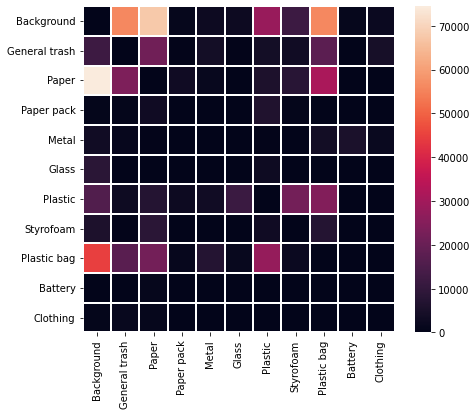

In [92]:
classes = ['Background','General trash','Paper','Paper pack','Metal','Glass','Plastic',
           'Styrofoam','Plastic bag','Battery','Clothing']

changed = np.zeros((11,11))
for info,num in dic.items():
    changed[int(info[0])][int(info[1])] = int(num)
    
plt.figure(figsize=(7,6))
sns.heatmap(changed,xticklabels=classes,yticklabels=classes,linewidth=0.1)
plt.show()

#### ensemble 결과 시각화
사용 방법: 확인하고자 하는 test set의 index를 index_list에 넣고 plot_examples(index_list) 실행

In [100]:
class_colormap = pd.read_csv("class_dict.csv")

def create_trash_label_colormap():
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    return colormap

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = create_trash_label_colormap()
    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')
    return colormap[label]

def plot_examples(index_list):
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    fig, ax = plt.subplots(nrows=len(index_list), ncols=3, figsize=(12, 4*len(index_list)), constrained_layout=True)
    for i,v in enumerate(index_list):
        folder = best['image_id'][v].split('/')[0]
        img_id = best['image_id'][v].split('/')[1]
        img_path = '../data/'+folder+'/'+img_id
        image = Image.open(img_path)
        best_mask = np.array(list(map(int,best['PredictionString'][v].split()))).reshape(256,256)
        ensemble_mask = np.array(list(map(int,ensemble['PredictionString'][v].split()))).reshape(256,256)
        ax[i][0].imshow(image)
        ax[i][0].set_title(f"Orignal Image")
        ax[i][1].imshow(label_to_color_image(best_mask))
        ax[i][1].set_title(f"Best(Single Model)")
        ax[i][2].imshow(label_to_color_image(ensemble_mask))
        ax[i][2].set_title(f"Ensemble")
        ax[i][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

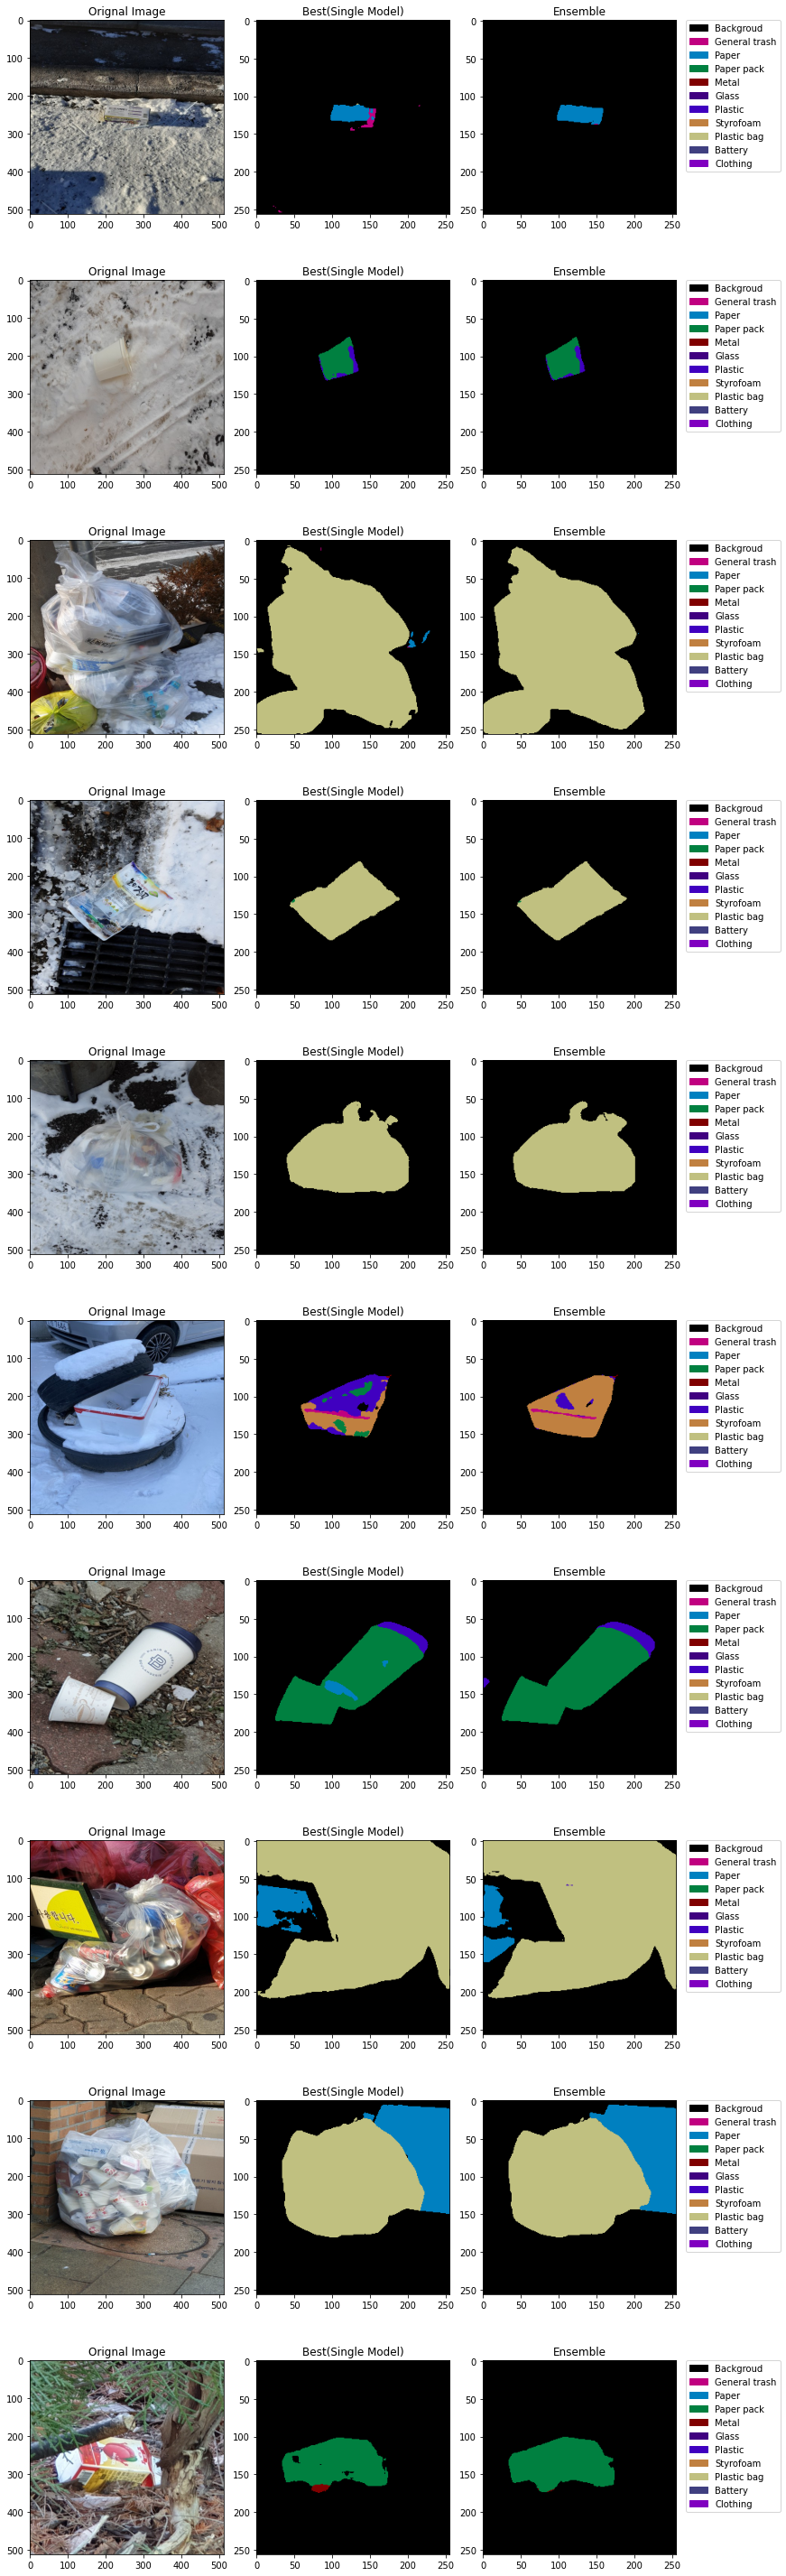

In [102]:
index_list = [x for x in range(20,30)]
plot_examples(index_list)